## Kaggle Mini Project Week 4 NLP Disaster Tweets Classification using LSTM and GRU

### Garrett Bainwol

####  [Github Repository Link ](https://github.com/gbainwol/DTSA5511_NLP_DISASTER_KAGGLE_PROJECT)


# Overview and Introduction

Because human languages have so many rules, words, and meanings, it is difficult for computers to understand them. We are able to use metaphorical language in our writing and speaking. Many people may disclose disasters and emergencies on the social media platform Twitter more quickly and easily than they can on news organizations, law enforcement, and/or government communication platforms. 
For this reason, it would be excellent if a computer could identify those emergency posts and categorize them so that emergency assistance can be provided and news organizations can spread the story more quickly. We must be able to distinguish between tweets that refer to actual emergencies or disasters and those that are not since people frequently use words with various meanings. To categorize text in natural languages, we will employ machine learning methods such as recursive neural networks (RNNs).



In [371]:
# install contractions if not already installed
!pip install contractions

#checking files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Libraries for project

In [372]:
# Library imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Text preprocessing
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,GRU

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Exploratory Data Analysis 

In [373]:
train_data = pd.read_csv(r"../input/nlp-getting-started/train.csv")
test_data = pd.read_csv(r"../input/nlp-getting-started/test.csv")
sample_data = pd.read_csv(r"../input/nlp-getting-started/sample_submission.csv")

In [374]:
train_data.sample(5)


,id,keyword,location,text,target
322,468,armageddon,"Rotterdam, Zuid-Holland",@AberdeenFC @AberdeenFanPage \n\nGood luck to ...,0
2354,3389,demolition,"ÌÏT: 36.142163,-95.979189",@samajp32 really needs to tone it down some in...,0
6573,9406,survivors,"SÌ£o Paulo, Brasil",Hiroshima survivors fight nuclear industry in ...,1
2587,3713,destroyed,buenos aires argentina,People donå«t want to hear the truth because t...,0
5821,8311,rubble,Phoenix Az,@JasonPope2 @JohnFugelsang again I didn't say ...,1


In [375]:
train_data.shape

(7613, 5)

In [376]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Examining a particular row that contains disaster text.**

In [377]:
train_data.iloc[3220]

id                                                       4620
keyword                                  emergency%20services
location                          Vancouver, British Columbia
text        Removing tsunami debris from the West Coast: K...
target                                                      1
Name: 3220, dtype: object

In [378]:
train_data.iloc[3220]['text']

'Removing tsunami debris from the West Coast: Karen Robinson Enviromental and Emergency services manager of the\x89Û_ http://t.co/1MeEo3WJcO'

In [379]:
test_data.sample(5)

,id,keyword,location,text
566,1849,burned,NaN,Corey White talking all dat shit but he got bu...
1564,5268,fear,USA,'Bear Markets Are Driven By Fear And Fear Has ...
2288,7646,panic,sad,Panic - Sublime with Rome
1140,3762,destruction,"lake worth, Fl",New RAN report from the frontlines of human ri...
376,1205,blizzard,Ideally under a big tree,That horrible moment when u open up the dryer ...


In [380]:
sample_data.sample(5)

,id,target
94,319,0
1383,4559,0
2081,6993,0
3219,10699,0
2440,8153,0


In [381]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [382]:
train_data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [383]:
test_data.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

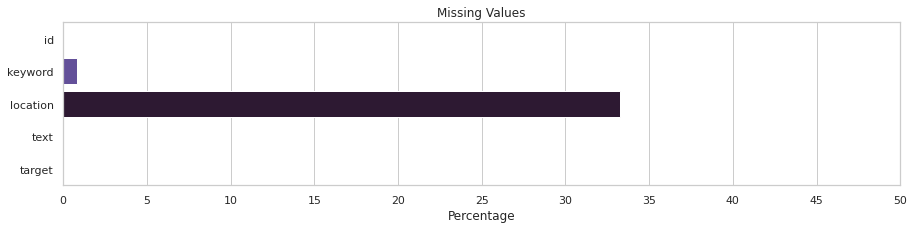

In [384]:
sns.set(style= "whitegrid")
percentages_missing = train_data.isna().sum() * 100 / len(train_data)

plt.figure(figsize=(15, 3))
sns.barplot(x=list(percentages_missing), 
            y=list(percentages_missing.index), 
            palette='twilight').set(title='Missing Values', 
                                     xlabel='Percentage', 
                                     xlim=(0,50),
                                     xticks=range(0,55, 5))
plt.show();

In [385]:
#Removing ID and location columns from train and test data 
train_data = train_data.drop(labels=['id','location'],axis=1)
test_data = test_data.drop(labels=['location'],axis=1)
train_data.sample(5)

,keyword,text,target
1853,crush,Ina Buted Girl Crush??,1
6489,sunk,The courtÛªs reputation and prestige has sunk...,0
5173,obliterate,Wondering if gold could gap up $50 on the jobs...,0
340,armageddon,Lee does comedy: ÛÏ@LeeJasper: Working class ...,0
1961,cyclone,@roughdeal1 ante hudhud cyclone Chandrababu Va...,1


In [386]:
 train_data['text'].duplicated().sum()

110

In [387]:
# Removing duplicated texts from column
train_data = train_data.drop_duplicates(subset=['text'],keep=False)

In [388]:
train_data.value_counts('target')

target
0    4284
1    3150
dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

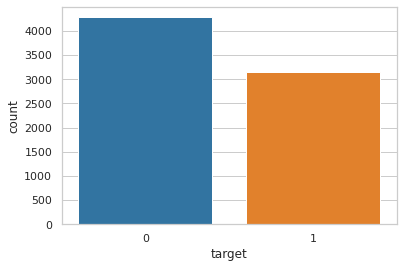

In [389]:
sns.set_theme(style="whitegrid")
sns.countplot(data= train_data, x ='target', palette = 'tab10')

In [390]:
# create two dataframes, one for real emergencies and one for fake emergencies
fake_DT = train_data[train_data['target']==0]
real_DT = train_data[train_data['target']==1]

In [391]:
print("10 Common Keywords for FAKE DISASTER Tweets")
fake_DT['keyword'].value_counts()[:10]

10 Common Keywords for FAKE DISASTER Tweets


body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
fear           35
twister        35
siren          35
Name: keyword, dtype: int64

In [392]:
print("10 Common Keywords for REAL DISASTER Tweets")
real_DT['keyword'].value_counts()[:10]

10 Common Keywords for REAL DISASTER Tweets


debris                37
oil%20spill           37
outbreak              37
wreckage              36
typhoon               35
evacuated             31
derailment            31
nuclear%20disaster    31
razed                 31
suicide%20bomber      30
Name: keyword, dtype: int64

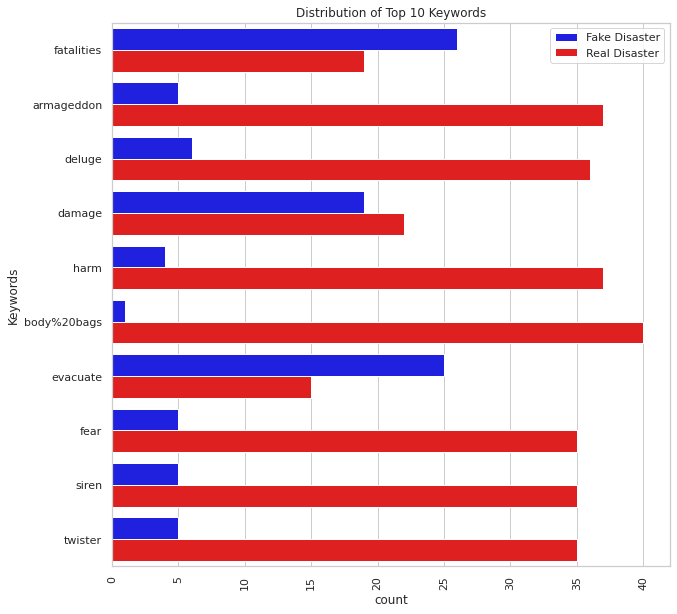

In [393]:
#plot distribution of top 10 keywords
plt.figure(figsize=[10, 10])

sns.countplot(y='keyword', 
              data=train_data.replace(0,'Real Disaster').replace(1,'Fake Disaster'),
              order=train_data['keyword'].value_counts()[:10].index,
              hue='target',palette=['blue', 'red']).set(title='Distribution of Top 10 Keywords', ylabel='Keywords')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show();

# Text Preprocessing

We notice a lot of URLs, HTML, @s, %20, and hashtags (#) since the data is text from a social media website. To deal with more concrete information that relates directly to the text, we will delete the URLS, HTMLS, and @ mentions. The #s and %20 will remain since they contain crucial information. On the Twitter website, the%20 seem to be the keywords, and hashtags are frequently used to draw attention to a word. Because of this, we will delete the symbols (%20 and #), but leave the text that go with them in tact. For the purpose of concentrating solely on the words, we will also eliminate punctuation.However, we will count the number of punctuation marks before eliminating the symbols because this information may be useful when we train the model.


The royn5618 helper function, which can be found at https://www.kaggle.com/code/nabanitaroy/eda-and-tf-idf-prediction-model-with-80-accuracy, served as an inspiration for the following helper functions. (Remove urls, htmls, @, and # signs, count, and punctuation)
We will apply the following to our dataframe and text column:

* Delete ‘location column’
* Remove URLs, HTMLs, and tags
* Count the number of punctuations present and delete them
* Lowercase all words
* Lemmatize words
* Declare if numbers appear and delete them
* Tokenize text
* Remove Digits

In [394]:
# remove digits from text
def remove_digits(text):
    return re.sub(r'[0-9]+', '', text)
# remove urls
def remove_urls(text):
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# remove hmtmls
def remove_html(text):
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# remove @ and #
def remove_tags(text):
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)

# count punctuation
def count_punctuation(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', text)
    return len(getpunctuation)

# put all words in lowercase
def lower_case(text):
    return text.lower()

In [395]:
STOPWORDS = set(stopwords.words('english'))
# clean and lemmatize words 
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in STOPWORDS and each_word.strip() != ''
    ]
    return " ".join(word_list)

In [396]:
# apply to training data
functions = [remove_urls, remove_html, remove_tags, count_punctuation, lower_case, preprocess_text, remove_digits]
for func in functions: 
    if func == count_punctuation:
        train_data['punctuation_count'] = train_data['text'].apply(func)
    else:
        train_data['text'] = train_data['text'].apply(func) 

In [397]:
# apply to test data
functions = [remove_urls, remove_html, remove_tags, count_punctuation, lower_case, preprocess_text, remove_digits]
for func in functions: 
    if func == count_punctuation:
        test_data['punctuation_count'] = test_data['text'].apply(func)
    else:
        test_data['text'] = test_data['text'].apply(func) 

In [398]:
train_data.sample(5)


,keyword,text,target,punctuation_count
1566,cliff%20fall,regress slip fall cliff,0,0
6191,sirens,added video youtube playlist cher lloyd siren,0,1
7073,upheaval,ancient mayan tablet found jungle temple,1,0
4208,hazard,londonfire hi email people use report sthing t...,1,5
3553,famine,building muscle feast famine feeding diet plan...,0,0


In [399]:
cleaned_text_train = train_data['text']
cleaned_text_test = test_data['text']

 # Model Structure and Outcomes 

We have ready-to-use training data for the models. Before training, the data will first be divided into training and validation sets.

We choose to use the LSTM and GRU RNN models for our project. Both models are quite straightforward to demonstrate how an RNN model's training need not be difficult. In actuality, LSTM and GRU models are constructed similarly to other neural networks, particularly when using Tensorflow Keras frameworks.

Long-Short Term Memory (LSTM) models are a subset of Recurrent Neural Networks (RNNs) that have particular data-processing gates. Here and/or here are excellent starting points for learning more about the LSTM mechanism.

Another excellent RNN model to test with text data is GRU --> Gated Recurrent Unit (GRU). In general, GRUs outperform LSTM models and can be quicker. More details regarding GRU models may be found here and/or here.

We'll take the next steps:


* Splitting the dataset into train, validation data
* Tokeninzing the train,validation and test data
* Padding the tokens
* Creating two different models LSTM and GRU 
* Run and submit predictions

In [400]:
X_train,X_val,y_train,y_val=train_test_split(cleaned_text_train,train_data['target'],test_size=0.3,random_state=40)
print(len(X_train),len(y_train))
print(len(X_val),len(y_val))

5203 5203
2231 2231


In [401]:
max_len=20

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer=Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_val=tokenizer.texts_to_sequences(X_val)
X_test=tokenizer.texts_to_sequences(cleaned_text_test)
X_train=pad_sequences(X_train,maxlen=max_len,padding='post')
X_val=pad_sequences(X_val,maxlen=max_len,padding='post')
X_test=pad_sequences(X_test,maxlen=max_len,padding='post')

In [402]:
vocab=len(tokenizer.word_index)+1
print("Vocab Size",vocab)

Vocab Size 11722


In [403]:
tf.keras.utils.to_categorical(y_train, num_classes=2)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [404]:
tf.keras.utils.to_categorical(y_val, num_classes= 2)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [405]:
print(y_train.shape)
print(y_val.shape)

(5203,)
(2231,)


In [406]:
import tensorflow.keras.backend as K
K.clear_session()

model=Sequential()
model.add(Embedding(vocab,100,input_length=max_len,trainable=True,mask_zero=True))
model.add(LSTM(300,dropout=0.1,recurrent_dropout=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1172200   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               481200    
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,672,729
Trainable params: 1,672,729
Non-trainable params: 0
_________________________________________________________________


In [407]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [408]:
history=model.fit(x=np.array(X_train),y=np.array(y_train),batch_size=1200,epochs=50,
          validation_data=(np.array(X_val),np.array(y_val)))

Epoch 1/50
5/5 [==============================] - 3s 222ms/step - loss: 0.6904 - acc: 0.5656 - val_loss: 0.6810 - val_acc: 0.5827
Epoch 2/50
5/5 [==============================] - 1s 142ms/step - loss: 0.6717 - acc: 0.5739 - val_loss: 0.6362 - val_acc: 0.6226
Epoch 3/50
5/5 [==============================] - 1s 306ms/step - loss: 0.5938 - acc: 0.7361 - val_loss: 0.5608 - val_acc: 0.7947
Epoch 4/50
5/5 [==============================] - 1s 140ms/step - loss: 0.4509 - acc: 0.8680 - val_loss: 0.5716 - val_acc: 0.7548
Epoch 5/50
5/5 [==============================] - 1s 137ms/step - loss: 0.3066 - acc: 0.8972 - val_loss: 0.5274 - val_acc: 0.7889
Epoch 6/50
5/5 [==============================] - 1s 136ms/step - loss: 0.2198 - acc: 0.9239 - val_loss: 0.5863 - val_acc: 0.7893
Epoch 7/50
5/5 [==============================] - 1s 137ms/step - loss: 0.1637 - acc: 0.9435 - val_loss: 0.7892 - val_acc: 0.7710
Epoch 8/50
5/5 [==============================] - 1s 145ms/step - loss: 0.1228 - acc: 0.95

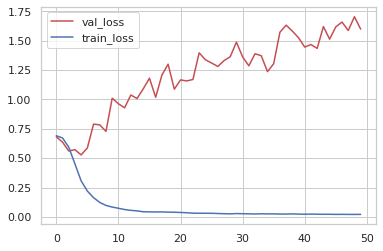

In [409]:
plt.plot(history.history['val_loss'],'r',label='val_loss')
plt.plot(history.history['loss'],'b',label='train_loss')
plt.legend()

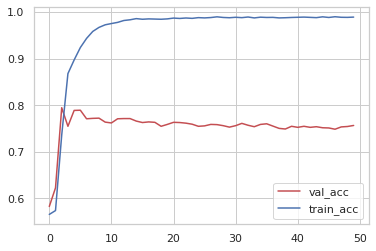

In [410]:
plt.plot(history.history['val_acc'],'r',label='val_acc')
plt.plot(history.history['acc'],'b',label='train_acc')
plt.legend()

In [411]:
predict=model.predict(X_test)

In [412]:
predict_final=[0 if i[0]>=0.5 else 1 for i in predict]
test_data['target']=predict_final

In [413]:
submission=test_data[['id','target']]
submission.to_csv('submission.csv',index=False)

This public score is terrible. Let's see whether adding GRU will make a difference.
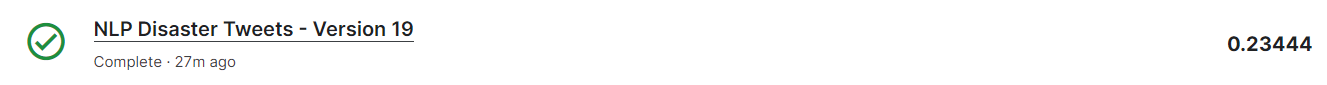

In [414]:
model2=Sequential()
model2.add(Embedding(vocab,100,input_length=max_len,trainable=True,mask_zero=True))
model2.add(GRU(300,dropout=0.1,recurrent_dropout=0.2))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1172200   
_________________________________________________________________
gru (GRU)                    (None, 300)               361800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,553,329
Trainable params: 1,553,329
Non-trainable params: 0
_________________________________________________________________


In [415]:
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [416]:
history2=model2.fit(x=np.array(X_train),y=np.array(y_train),batch_size=1200,epochs=50,
          validation_data=(np.array(X_val),np.array(y_val)))

Epoch 1/50
5/5 [==============================] - 3s 211ms/step - loss: 0.6885 - acc: 0.5714 - val_loss: 0.6770 - val_acc: 0.5827
Epoch 2/50
5/5 [==============================] - 1s 118ms/step - loss: 0.6692 - acc: 0.5735 - val_loss: 0.6509 - val_acc: 0.5840
Epoch 3/50
5/5 [==============================] - 1s 117ms/step - loss: 0.6056 - acc: 0.6562 - val_loss: 0.5669 - val_acc: 0.7485
Epoch 4/50
5/5 [==============================] - 1s 120ms/step - loss: 0.4675 - acc: 0.8451 - val_loss: 0.4998 - val_acc: 0.7727
Epoch 5/50
5/5 [==============================] - 1s 117ms/step - loss: 0.3130 - acc: 0.8908 - val_loss: 0.5342 - val_acc: 0.7741
Epoch 6/50
5/5 [==============================] - 1s 123ms/step - loss: 0.1980 - acc: 0.9270 - val_loss: 0.5637 - val_acc: 0.7978
Epoch 7/50
5/5 [==============================] - 1s 156ms/step - loss: 0.1408 - acc: 0.9483 - val_loss: 0.7116 - val_acc: 0.7799
Epoch 8/50
5/5 [==============================] - 1s 148ms/step - loss: 0.1011 - acc: 0.96

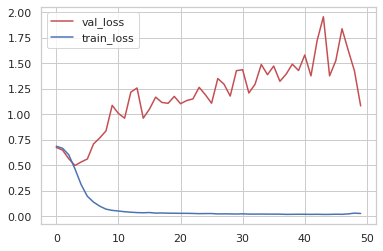

In [417]:
plt.plot(history2.history['val_loss'],'r',label='val_loss')
plt.plot(history2.history['loss'],'b',label='train_loss')
plt.legend()

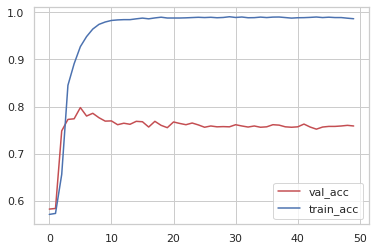

In [418]:
plt.plot(history2.history['val_acc'],'r',label='val_acc')
plt.plot(history2.history['acc'],'b',label='train_acc')
plt.legend()

In [419]:
predict=model2.predict(X_test)

In [420]:
predict_final=[0 if i[0]>=0.5 else 1 for i in predict]
test_data['target']=predict_final

In [422]:
submission=test_data[['id','target']]
submission.to_csv('submission.csv',index=False)

A slight improvement but not much of a change. 
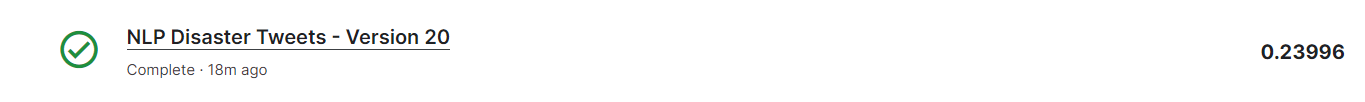

# Analysis

Certainly disheartening is how our models fared. There are a number potential causes for this, including:

* Our model(s) did not generalize well to new data because they were overfit to the training data and were too simplistic for the given data.
* We also cleaned the data improperly for this data.
* There wasn't enough data to train the model(s) with, or they weren't the correct model for the project. 
* The suspicion is that our models were overfitted and overly simplistic, however there are numerous other explanations for why our model did somewhat better than random guessing.

# Conclusion



Before we cleaned the data, we first imported it to have a decent idea of how the training data appears. We also made a lot of the data visual. The training data was then preprocessed by counting punctuation, changing the appearance of the numbers, and changing the language to make it simpler for a computer to grasp. In order to effectively train our models, we divided the training data into two subsets, training and validation, once it was ready. Then, by outlining their hyperparameters, structures, and optimizers, we trained the two models—LSTM and GRU—that we had previously defined in great detail. Finally, we ran both models through the testing phase, and the Kaggle competition page displayed our F1 score.The models didn't perform as well as we had hoped overall. These two models, however, were both quite straightforward and likely overfitted to the training set of data. We believed we had a fair notion of how the models would perform based on the graphs displaying the various metrics per epoch utilized in each model; they appeared to be performing well! It's important to remember that just because your model appears to perform well on training and validation data, it doesn't necessarily follow that it will do so on new data. Our models are a prime illustration of this. Perhaps using additional data, a different text cleaning technique, fewer epochs (to avoid overfitting), or even a new model structure would have yielded better results.



In [ ]:
a